In [1]:
# generic python imports
from __future__ import division
import numpy as np
from IPython.display import HTML, display

import scipy
from scipy.special import erf
from scipy.stats import gaussian_kde
from scipy import integrate

import os,sys,subprocess
import h5py 
import hashlib  
import corner

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib.lines import Line2D as ld

# figure fonts
matplotlib.rc('text', usetex=True)  
matplotlib.rcParams['text.latex.preamble'] = [r"\usepackage{bm}"]
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

# LIGO-specific software; install with conda or pip
import lal                                          # https://pypi.org/project/lalsuite/
from pesummary.gw.file.read import read as GWread   # https://pypi.org/project/pesummary/
from ligo.skymap.io import fits                     # https://pypi.org/project/ligo.skymap/

In [2]:


# put figures in a sub-directory:
figpath = 'GW190521_Implications_Figures_pdf/' 
if not os.path.exists(figpath):
    os.makedirs(figpath)



In [21]:


#===============
# PE SAMPLES 
#===============

# read in PE sample files, check md5sum against https://dcc.ligo.org/public/0166/P2000158/002/GW190521_md5sums.txt

#------------------------------------
# a. Inspiral-Merger-Ringdown waveform model Posterior PE samples
#------------------------------------

posterior_samples_file='GW190521_posterior_samples.h5'

samples_file = h5py.File(posterior_samples_file,'r')

seob = samples_file['SEOBNRv4PHM']['posterior_samples']
print(seob)
samples_dict = dict(SEOB=seob)
print(samples_dict)

parameter_1 = 'chi_eff'
parameter_2 = 'mass_ratio'
par_x = samples_dict["SEOB"][parameter_1]
par_y = samples_dict["SEOB"][parameter_2]
par_x.shape

<HDF5 dataset "posterior_samples": shape (19822,), type "|V408">
{'SEOB': <HDF5 dataset "posterior_samples": shape (19822,), type "|V408">}


(19822,)

In [18]:
a = dict(x=1, y=2)
a

{'x': 1, 'y': 2}

In [10]:
#========================
# Bounded KDE function, used to smoothe 1-D posterior distributions.
#========================

class Bounded_kde(gaussian_kde):
    r"""Represents a one-dimensional Gaussian kernel density estimator
    for a probability distribution function that exists on a bounded
    domain."""

    def __init__(self, pts, low=None, high=None, *args, **kwargs):
        """Initialize with the given bounds.  Either ``low`` or
        ``high`` may be ``None`` if the bounds are one-sided.  Extra
        parameters are passed to :class:`gaussian_kde`.

        :param low: The lower domain boundary.

        :param high: The upper domain boundary."""
        pts = np.atleast_1d(pts)

        assert pts.ndim == 1, 'Bounded_kde can only be one-dimensional'
        
        super(Bounded_kde, self).__init__(pts, *args, **kwargs)

        self._low = low
        self._high = high

    @property
    def low(self):
        """The lower bound of the domain."""
        return self._low

    @property
    def high(self):
        """The upper bound of the domain."""
        return self._high

    def evaluate(self, xs):
        """Return an estimate of the density evaluated at the given
        points."""
        xs = np.atleast_1d(xs)
        assert xs.ndim == 1, 'points must be one-dimensional'

        pdf = super(Bounded_kde, self).evaluate(xs)

        if self.low is not None:
            pdf += super(Bounded_kde, self).evaluate(2.0*self.low - xs)

        if self.high is not None:
            pdf += super(Bounded_kde, self).evaluate(2.0*self.high - xs)

        return pdf

    __call__ = evaluate

In [28]:
#========================
# PLOTTING FUNCTIONS 
#========================

#-------------------------------------------
# a. Plot with 2D contour + x,y histogram
#-------------------------------------------
def triangle_plot_2d_axes(
    xbounds, ybounds, figsize=(8, 8),
    width_ratios=[4, 1], height_ratios=[1, 4], wspace=0.0, hspace=0.0,
    grid=False,high1d=1):
    """Initialize the axes for a 2d triangle plot.
    """
    high1d = high1d

    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(
        2, 2,
        width_ratios=width_ratios, height_ratios=height_ratios,
        wspace=wspace, hspace=hspace)

    ax1 = plt.subplot(gs[0])
    ax3 = plt.subplot(gs[2])
    ax4 = plt.subplot(gs[3])

    ax1.minorticks_on()
    ax3.minorticks_on()
    ax4.minorticks_on()

    if grid:
        ax1.grid(which='major', ls='-')
        ax1.grid(which='minor', ls=':')
        ax3.grid(which='major', ls='-')
        ax3.grid(which='minor', ls=':')
        ax4.grid(which='major', ls='-')
        ax4.grid(which='minor', ls=':')

    # Get rid of tick labels
    ax1.xaxis.set_ticklabels([])
    ax4.yaxis.set_ticklabels([])

    # Use consistent x-axis and y-axis bounds in all 3 plots
    ax1.set_ylim(0, high1d)
    ax1.set_xlim(xbounds[0], xbounds[1])
    ax3.set_xlim(xbounds[0], xbounds[1])
    ax3.set_ylim(ybounds[0], ybounds[1])
    ax4.set_xlim(0, high1d)
    ax4.set_ylim(ybounds[0], ybounds[1])

    return fig, ax1, ax3, ax4


def create_fig_and_axes(xbounds, ybounds, figsize=(9.7, 9.7),high1d=1):
    fig, ax1, ax3, ax4 = triangle_plot_2d_axes(
        xbounds, ybounds, figsize=figsize, width_ratios=[4, 1],
        height_ratios=[1, 4], wspace=0.0, hspace=0.0,high1d=high1d)
    return fig, ax1, ax3, ax4





#------------------------------------------------------------
# b. Plotting the main result: NRSur PHM (filled Contour)
#------------------------------------------------------------

def add_samples_to_fig(name, parameter_1,parameter_2,zorder=10,norm_factor_x=1,norm_factor_y=1,bounded_1=False,low_1=None,high_1=None,bounded_2=False,low_2=None,high_2=None):
    
    #name: name of pe result to plot
    #parameter 1 and parameter 2: parameters to plot in the 2D plot
    #zorder: if plottting multiple results, a larger zorder places the contour on top
    #norm_factor_x,y: parameter to scale the corner 1D histograms
    
    x = samples_dict[name][parameter_1]
    y = samples_dict[name][parameter_2]
    xlow, xhigh = xlims
    xsmooth = np.linspace(xlow, xhigh, 1000)
    ylow, yhigh = ylims
    ysmooth = np.linspace(ylow, yhigh, 1000)

    norm_factor_x=0.95*norm_factor_x
    norm_factor_y=0.95*norm_factor_y
    
    c = color_dict[name]
    label = label_dict[name]
    alpha = alpha_dict[name]
    lw = lw_dict[name]
    bb = bins_dict[name]    


    if bounded_1==True:                     
        if parameter_1 == 'chi_p':
            guess = lambda x: x * (1.-x)
            kde = gaussian_kde(x, weights=1./guess(x))
            guess_norm = integrate.quad(guess, low_1, high_1)[0]

            ax1.plot(xsmooth, norm_factor_x* kde(xsmooth) * guess(xsmooth) / guess_norm, color=c, lw=lw, label=label,
             zorder=zorder)
        
            ax1.fill_between(xsmooth, 0, norm_factor_x* kde(xsmooth) * guess(xsmooth) / guess_norm, color=c, alpha=alpha,
                     zorder=zorder)
            
        elif parameter_1 == 'theta_jn':
            guess = lambda x: x * (np.pi-x)
            kde = gaussian_kde(x, weights=1./guess(x))
            guess_norm = integrate.quad(guess, low_1, high_1)[0]

            ax1.plot(xsmooth, norm_factor_x* kde(xsmooth) * guess(xsmooth), color=c, lw=lw, label=label,
             zorder=zorder)
        
            ax1.fill_between(xsmooth, 0, norm_factor_x* kde(xsmooth) * guess(xsmooth), color=c, alpha=alpha,
                     zorder=zorder)
         
        else:       
            print("Using bounded KDE")   
            kde = Bounded_kde(x,low=low_1,high=high_1)
            ax1.plot(xsmooth, norm_factor_x*kde(xsmooth), color=c, lw=lw, label=label,
                     zorder=zorder)
            ax1.fill_between(xsmooth, 0, norm_factor_x*kde(xsmooth), color=c, alpha=alpha,
                             zorder=zorder)            
        
    else:         
        kde = gaussian_kde(x)

        ax1.plot(xsmooth, norm_factor_x*kde(xsmooth), color=c, lw=lw, label=label,
                 zorder=zorder)
        ax1.fill_between(xsmooth, 0, norm_factor_x*kde(xsmooth), color=c, alpha=alpha,
                         zorder=zorder)
    ax1.axvline(np.quantile(x, 0.05), color=c, ls='dashed')
    ax1.axvline(np.quantile(x, 0.95), color=c, ls='dashed')

    if bounded_2==True:        
        print("Using bounded KDE")    
        kde = Bounded_kde(y,low=low_2,high=high_2)    
    else:         
        kde = gaussian_kde(y)
        
    ax4.plot(norm_factor_y*kde(ysmooth), ysmooth, color=c, lw=lw, label=label,
             zorder=zorder)
    ax4.fill_betweenx(ysmooth, 0, norm_factor_y*kde(ysmooth), color=c, alpha=alpha,
                      zorder=zorder)
    ax4.axhline(np.quantile(y, 0.05), color=c, ls='dashed')
    ax4.axhline(np.quantile(y, 0.95), color=c, ls='dashed')
    

###### For the case of m1, m2 reflect samples at m1=m2 to correctly treat the boundary #######
    
    if parameter_1 == 'mass_1_source' and parameter_2 == 'mass_2_source':       
        print("Symmetrising samples around m1=m2")    
        # symmetrize the samples over 1<->2
        x_temp = np.concatenate((x, y))
        y_temp = np.concatenate((y, x))        
        x=x_temp
        y=y_temp    
    else:        
        print("No reflexion done")
    
    my_range = [[xlow, xhigh], [ylow, yhigh]]
    corner.hist2d(x, y, ax=ax3, range=my_range, color=c,
                  plot_datapoints=False, plot_density=True,smooth=True,
                  levels=[0.9],fill_contours=False,bins=bb, lw=4)

    
#----------------------------------------------------------------------------
# c. Plotting other models: Phenom PHM, SEOBNR PHM (transparent contours)
#-----------------------------------------------------------------------------

def add_samples_to_fig_nofilled(name, parameter_1,parameter_2,zorder=10,norm_factor_x=1,norm_factor_y=1,bounded_1=False,low_1=None,high_1=None,bounded_2=False,low_2=None,high_2=None):
    
    x = parameter_1
    y = parameter_2
    xlow, xhigh = xlims
    xsmooth = np.linspace(xlow, xhigh, 1000)
    ylow, yhigh = ylims
    ysmooth = np.linspace(ylow, yhigh, 1000)

    norm_factor_x=0.95*norm_factor_x
    norm_factor_y=0.95*norm_factor_y
    
    c = color_dict[name]
    label = label_dict[name]
    alpha = alpha_dict[name]
    lw = lw_dict[name]
    bb = bins_dict[name]

    if bounded_1==True:                     
        if parameter_1 == 'chi_p':
            guess = lambda x: x * (1.-x)
            kde = gaussian_kde(x, weights=1./guess(x))
            guess_norm = integrate.quad(guess, low_1, high_1)[0]

            ax1.plot(xsmooth, norm_factor_x* kde(xsmooth) * guess(xsmooth) / guess_norm, color=c, lw=lw, label=label,
             zorder=zorder)
            
        elif parameter_1 == 'theta_jn':
            guess = lambda x: x * (np.pi-x)
            kde = gaussian_kde(x, weights=1./guess(x))
            guess_norm = integrate.quad(guess, low_1, high_1)[0]

            ax1.plot(xsmooth, norm_factor_x* kde(xsmooth) * guess(xsmooth), color=c, lw=lw, label=label,
             zorder=zorder)
                  
        else:       
            print("Using bounded KDE")   
            kde = Bounded_kde(x,low=low_1,high=high_1)          
            ax1.plot(xsmooth, norm_factor_x*kde(xsmooth), color=c, lw=lw, label=label,
                     zorder=zorder)            
    else:         
        kde = gaussian_kde(x)    
    
        ax1.plot(xsmooth, norm_factor_x*kde(xsmooth), color=c, lw=lw, label=label,
                 zorder=zorder)
    ax1.axvline(np.quantile(x, 0.05), color=c, ls='dashed')
    ax1.axvline(np.quantile(x, 0.95), color=c, ls='dashed')

    
    if bounded_2==True:        
        print("Using bounded KDE")    
        kde = Bounded_kde(y,low=low_2,high=high_2)    
    else:         
        kde = gaussian_kde(y)    
    
    ax4.plot(norm_factor_y*kde(ysmooth), ysmooth, color=c, lw=lw, label=label,
             zorder=zorder)
    ax4.axhline(np.quantile(y, 0.05), color=c, ls='dashed')
    ax4.axhline(np.quantile(y, 0.95), color=c, ls='dashed')

###### For the case of m1, m2 reflect samples at m1=m2 to correctly treat the boundary #######
    
    if parameter_1 == 'mass_1_source' and parameter_2 == 'mass_2_source':       
        print("Symmetrising samples around m1=m2")    
        # symmetrize the samples over 1<->2
        x_temp = np.concatenate((x, y))
        y_temp = np.concatenate((y, x))        
        x=x_temp
        y=y_temp    
    else:        
        print("No reflexion done")
        
    my_range = [[xlow, xhigh], [ylow, yhigh]]
    corner.hist2d(x, y, ax=ax3, range=my_range, color=c,
                  plot_datapoints=False, plot_density=False,smooth=True,#levels=(np.exp(-0.5),np.exp(-1)),
                  levels=[0.9],no_fill_contour=False,bins=bb, lw=4,
                 )

    

#----------------------------------------------------------------------------
# e. Plotting prior (1D histograms)
#-----------------------------------------------------------------------------
       
    
def add_prior(name, parameter_1,parameter_2,zorder=10,norm_factor_x=1,norm_factor_y=1,bounded_1=False,low_1=None,high_1=None,bounded_2=False,low_2=None,high_2=None):
        
    x = samples_dict[name][parameter_1]
    y = samples_dict[name][parameter_2]
    
    xlow, xhigh = xlims
    xsmooth = np.linspace(xlow, xhigh, 10000)
    ylow, yhigh = ylims
    ysmooth = np.linspace(ylow, yhigh, 10000)

    norm_factor_x=0.95*norm_factor_x
    norm_factor_y=0.95*norm_factor_y
    
    #c = color_dict[name]
    label = 'Prior'
    alpha = 0.0
    lw = 3
    c='black'

    if bounded_1==True:        
        print("Using bounded KDE")    
        kde = Bounded_kde(x,low=low_1,high=high_1)    
    else:         
        kde = gaussian_kde(x)        
       
    ax1.plot(xsmooth, norm_factor_x*kde(xsmooth), color=c, lw=lw, label=label,
             zorder=zorder)
    ax1.fill_between(xsmooth, 0, norm_factor_x*kde(xsmooth), color=c, alpha=alpha,
                     zorder=zorder)

    if bounded_2==True:        
        print("Using bounded KDE")    
        kde = Bounded_kde(y,low=low_2,high=high_2)    
    else:         
        kde = gaussian_kde(y)    
    
    ax4.plot(norm_factor_y*kde(ysmooth), ysmooth, color='black', lw=lw, label=label,
             zorder=zorder)
    #ax4.axis('off')
    ax4.fill_betweenx(ysmooth, 0, norm_factor_y*kde(ysmooth), color=c, alpha=alpha,
                      zorder=zorder)

    my_range = [[xlow, xhigh], [ylow, yhigh]]
    

    
    
def add_prior_bounded(name, parameter_1,parameter_2,zorder=10,norm_factor_x=1,norm_factor_y=1,bounded_1=False,low_1=None,high_1=None,bounded_2=False,low_2=None,high_2=None):
    
    x = samples_dict[name][parameter_1][()]
    y = samples_dict[name][parameter_2][()]
    
    xlow, xhigh = xlims
    xsmooth = np.linspace(xlow, xhigh, 10000)
    ylow, yhigh = ylims
    ysmooth = np.linspace(ylow, yhigh, 10000)

    norm_factor_x=0.95*norm_factor_x
    norm_factor_y=0.95*norm_factor_y
    
    #c = color_dict[name]
    label = 'Prior'
    alpha = 0.3
    lw = 3
    ls = 'solid'
    kde = gaussian_kde(x)
    
    c='black'
    
    if bounded_1==True:                     
        if parameter_1 == 'chi_p':
            guess = lambda x: x * (1.-x)
            kde = gaussian_kde(x, weights=1./guess(x))
            guess_norm = integrate.quad(guess, low_1, high_1)[0]

            ax1.plot(xsmooth, norm_factor_x* kde(xsmooth) * guess(xsmooth) / guess_norm, color=c, lw=lw, label=label,
             zorder=zorder)
            
        elif parameter_1 == 'theta_jn':
            guess = lambda x: x * (np.pi-x)
            kde = gaussian_kde(x, weights=1./guess(x))
            guess_norm = integrate.quad(guess, low_1, high_1)[0]

            ax1.plot(xsmooth, norm_factor_x* kde(xsmooth) * guess(xsmooth), color=c, lw=lw, label=label,
             zorder=zorder)
                  
        else:       
            print("Using bounded KDE")   
            kde = Bounded_kde(x,low=low_1,high=high_1)          
            ax1.plot(xsmooth, norm_factor_x*kde(xsmooth), color=c, lw=lw, label=label,
                     zorder=zorder)            
    else:         
        kde = gaussian_kde(x)    
    
        ax1.plot(xsmooth, norm_factor_x*kde(xsmooth), color=c, lw=lw, label=label,
                 zorder=zorder)

    
    if bounded_2==True:        
        print("Using bounded KDE")    
        kde = Bounded_kde(y,low=low_2,high=high_2)    
    else:         
        kde = gaussian_kde(y)    
    
    ax4.plot(norm_factor_y*kde(ysmooth), ysmooth, color=c, lw=lw, label=label,
             zorder=zorder)

    
#----------------------------------------------------------------------------
# f. Plotting Ring Down modes: Phenom PHM, SEOBNR PHM (transparent contours)
#-----------------------------------------------------------------------------

def add_samples_to_fig_rd(name, parameter_1,parameter_2,zorder=10,norm_factor_x=1,norm_factor_y=1,bounded=False):
    
    x = samples_dict[name][parameter_1]
    y = samples_dict[name][parameter_2]
    xlow, xhigh = xlims
    xsmooth = np.linspace(xlow, xhigh, 1000)
    ylow, yhigh = ylims
    ysmooth = np.linspace(ylow, yhigh, 1000)

    norm_factor_x=0.95*norm_factor_x
    norm_factor_y=0.95*norm_factor_y
    
    c = color_dict[name]
    label = label_dict[name]
    alpha = alpha_dict[name]
    lw = lw_dict[name]
    #ls = ls_dict[name]
        
    kde = gaussian_kde(x)
    bb = bins_dict[name]   
    
    ax1.plot(xsmooth, norm_factor_x*kde(xsmooth), color=c, lw=lw, label=label,
             zorder=zorder)
    #ax1.axis('off')
    ax1.axvline(np.quantile(x, 0.05), color=c, ls='none')
    ax1.axvline(np.quantile(x, 0.95), color=c, ls='none')

    kde = gaussian_kde(y)
    
    ax4.plot(norm_factor_y*kde(ysmooth), ysmooth, color=c, lw=lw, label=label,
             zorder=zorder)

 #                     zorder=zorder)
    ax4.axhline(np.quantile(y, 0.05), color=c, ls='none')
    ax4.axhline(np.quantile(y, 0.95), color=c, ls='none')
    
    my_range = [[xlow, xhigh], [ylow, yhigh]]
    corner.hist2d(x, y, ax=ax3, range=my_range, color=c, ls='dashed',
                  plot_datapoints=False, plot_density=False,smooth=True,#levels=(np.exp(-0.5),np.exp(-1)),
                  levels=[0.9],no_fill_contour=False,bins=bb, lw=4, alpha=0.2
                 )

{'SEOB': <HDF5 dataset "posterior_samples": shape (19822,), type "|V408">}


/tmp/ipykernel_360255/413664247.py:187: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if parameter_1 == 'chi_p':
/tmp/ipykernel_360255/413664247.py:195: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif parameter_1 == 'theta_jn':


Using bounded KDE
Using bounded KDE


/tmp/ipykernel_360255/413664247.py:230: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if parameter_1 == 'mass_1_source' and parameter_2 == 'mass_2_source':


No reflexion done
Saving


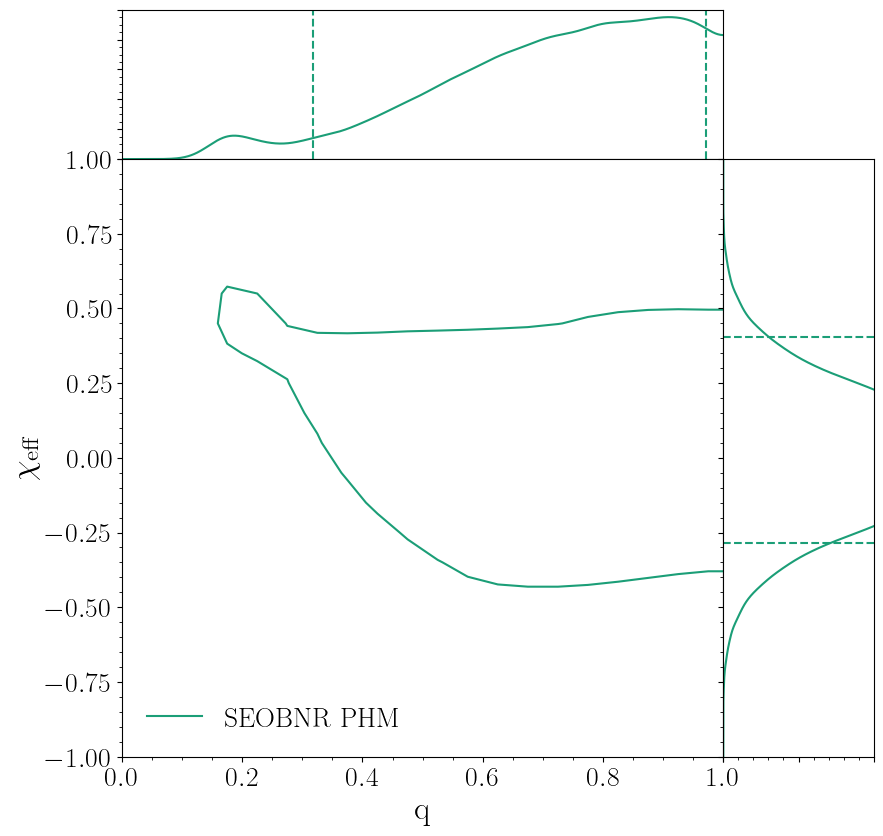

In [29]:


#==========================================
# Fig-8: chi_p-q plot with NR simulations 
#=========================================

samples_dict = dict(SEOB=seob)
print(samples_dict)
for key in samples_dict:
    samples_dict[key] = samples_dict[key]

color_dict = dict(SEOB="#1b9e77")
label_dict = dict(SEOB="SEOBNR PHM")
alpha_dict = dict(SEOB=0.2)
lw_dict = dict(SEOB=1.5)
bins_dict = dict(SEOB=20)


parameter_1 = 'chi_eff'
parameter_2 = 'mass_ratio'
par_x = samples_dict["SEOB"][parameter_1]
par_y = samples_dict["SEOB"][parameter_2]
xlims = [0, 1]
ylims = [-1, 1]

norm_factor = 1.60


fig, ax1, ax3, ax4 = create_fig_and_axes(xlims, ylims)
ax3.set_ylabel(r"$\chi_\mathrm{eff}$",fontsize=24)
ax3.set_xlabel(r"q",fontsize=24)
ax3.tick_params(labelsize=10)

my_array_x=np.linspace(xlims[0],xlims[1],1000)
my_array_y=np.linspace(ylims[0],ylims[1],1000)


r3x=1/np.max(scipy.stats.gaussian_kde(seob[parameter_1])(my_array_x))
r3y=1/np.max(scipy.stats.gaussian_kde(seob[parameter_2])(my_array_y))



norm_factor_x = np.min([r3x])
norm_factor_y = np.min([r3y])

add_samples_to_fig_nofilled("SEOB",par_y,par_x,zorder=-10,
norm_factor_x=norm_factor_y,norm_factor_y=norm_factor_x,bounded_1=True,low_1=0,high_1=1,bounded_2=True,low_2=0,high_2=1)


ax3.set_xlim(*xlims)
ax1.set_yticklabels([],fontsize=10)
ax4.set_xticklabels([],fontsize=20)
ax3.legend(*ax4.get_legend_handles_labels(), loc=3, frameon=False,prop={'size': 20})
ax3.tick_params(axis='both', labelsize=20)

print("Saving")
fig.savefig(figpath+'NRqchip_vf.pdf',format='pdf', transparent=True, bbox_inches='tight')



In [42]:
samples_dict["SEOB"]['spin_2y']

array([ 0.34851885,  0.43403227,  0.00059008, ...,  0.05499879,
        0.46778219, -0.09458821])